In [1]:
!nvidia-smi

Sun Mar 28 00:06:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:01:00.0  On |                  N/A |
| N/A   73C    P2    43W /  N/A |    320MiB /  8111MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
if not os.path.isdir('keras-retinanet'):
    !git clone https://github.com/fizyr/keras-retinanet.git

In [3]:
#!pip install --upgrade keras

In [4]:
%cd keras-retinanet/
!ls
if 0:
    !pip install .
    !python setup.py build_ext --inplace
    !pip install gdown
    !pip install tensorflow-gpu

/home/skycam/sample_projs/mask_Retina/RetinaNet_mask/keras-retinanet
alldata.csv	       CONTRIBUTORS.md	maskdb		  snapshots
annotations.csv        examples		README.md	  tests
annotations-plate.csv  images		requirements.txt  xml2csv.py
build		       keras_retinanet	setup.cfg
classes.csv	       LICENSE		setup.py


In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
#if not os.path.isfile('indian_number_plates.json'):
#    !gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json
#!head indian_number_plates.json

In [7]:
os.makedirs("snapshots", exist_ok=True)

In [8]:
#if not os.path.isfile('snapshots/resnet50_csv_10.h5'):
#    !gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

In [9]:
#https://curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/
#https://colab.research.google.com/drive/1ldnii3sGJaUHPV6TWImykbeE_O-8VIIN#scrollTo=5DgiQ4FR0go6

In [10]:
#plates_df = pd.read_json('indian_number_plates.json', lines=True)

In [11]:
#plates_df

In [12]:
os.makedirs("maskdb", exist_ok=True)

In [13]:
#ipython console --existing 4604c4c3

In [14]:
df = pd.read_csv('alldata.csv')
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,maskdb/train/48.jpg,107,27,193,135,nomask
1,maskdb/train/augmented_image_206.jpg,87,110,262,373,mask
2,maskdb/train/pexels-photo-4048805.jpeg,924,298,1100,582,nomask
3,maskdb/train/54.jpg,78,96,267,343,nomask
4,maskdb/train/43.jpg,46,103,258,372,nomask


In [15]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  
  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

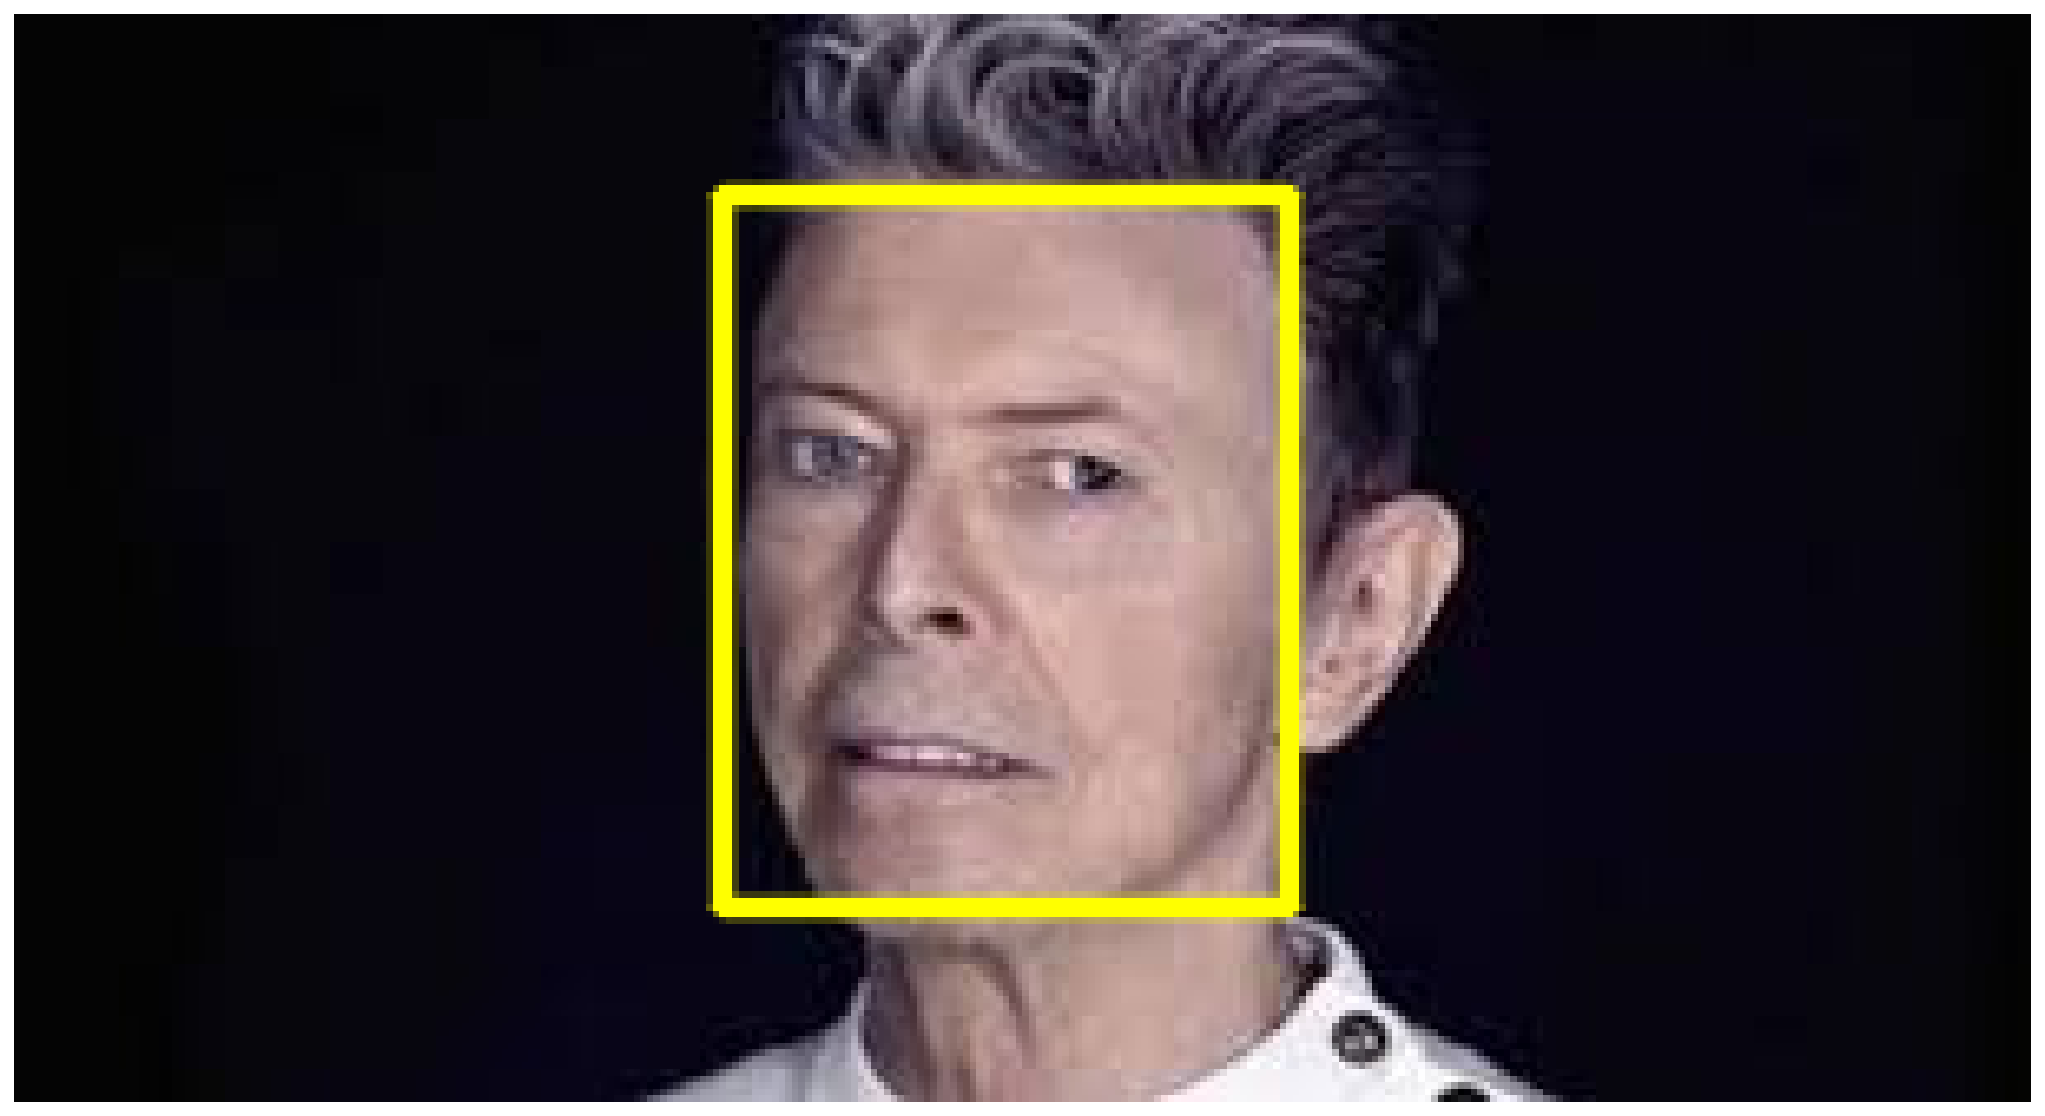

In [16]:
show_image_objects(df.iloc[0])

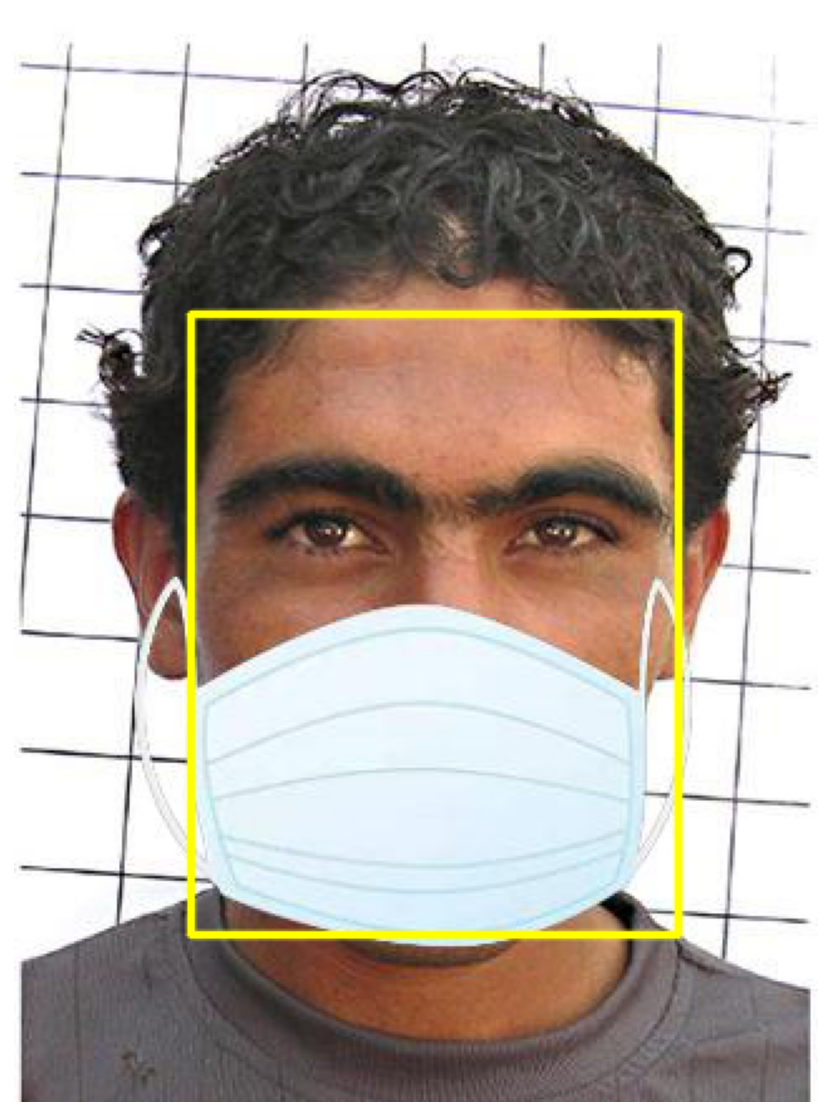

In [17]:
show_image_objects(df.iloc[5])

# Preprocessing

In [18]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [19]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [20]:
train_df

,image_name,x_min,y_min,x_max,y_max,class_name
31,maskdb/train/34.jpg,40,77,151,240,nomask
58,maskdb/train/37.jpg,50,42,120,129,nomask
9,maskdb/train/16-with-mask.jpg,88,116,232,308,mask
5,maskdb/train/27-with-mask.jpg,70,119,264,366,mask
35,maskdb/train/57.jpg,26,151,270,496,nomask
...,...,...,...,...,...,...
20,maskdb/train/augmented_image_195.jpg,31,25,154,189,mask
60,maskdb/train/61.jpg,98,89,240,306,nomask
71,maskdb/train/augmented_image_184.jpg,76,40,146,131,mask
14,maskdb/train/23.jpg,56,48,139,155,nomask


In [21]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [22]:
classes = set(['mask','nomask'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [23]:
!head classes.csv

mask,0
nomask,1


In [24]:
!head annotations.csv

maskdb/train/34.jpg,40,77,151,240,nomask
maskdb/train/37.jpg,50,42,120,129,nomask
maskdb/train/16-with-mask.jpg,88,116,232,308,mask
maskdb/train/27-with-mask.jpg,70,119,264,366,mask
maskdb/train/57.jpg,26,151,270,496,nomask
maskdb/train/17.jpg,98,195,238,378,nomask
maskdb/train/19.jpg,85,132,265,351,nomask
maskdb/train/augmented_image_257.jpg,133,48,258,219,mask
maskdb/train/augmented_image_261.jpg,54,121,246,351,mask
maskdb/train/13-with-mask.jpg,213,59,331,218,mask


# Training

In [25]:
if 0:
    PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
    if not os.path.isfile(PRETRAINED_MODEL):
        URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
        urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

        print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

In [26]:
PRETRAINED_MODEL = './snapshots/resnet50_csv_.h5'

In [27]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 4 --steps 10 --epochs 300 csv annotations.csv classes.csv

2021-03-28 00:06:48.237597: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2021-03-28 00:06:49.475014: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-03-28 00:06:49.507030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-28 00:06:49.507841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.771GHz coreCount: 20 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 298.32GiB/s
2021-03-28 00:06:49.507921: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-03-28 00:06:49.509

Epoch 1/300
2021-03-28 00:06:57.959127: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-03-28 00:06:58.663825: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
10/10 [==============================] - ETA: 0s - loss: 1.2035 - regression_loss: 0.9629 - classification_loss: 0.2406
Epoch 00001: loss improved from inf to 1.20351, saving model to ./snapshots/resnet50_csv_.h5
10/10 [==============================] - 20s 2s/step - loss: 1.2035 - regression_loss: 0.9629 - classification_loss: 0.2406
Epoch 2/300
10/10 [==============================] - ETA: 0s - loss: 1.1680 - regression_loss: 0.9117 - classification_loss: 0.2564
Epoch 00002: loss improved from 1.20351 to 1.16801, saving model to ./snapshots/resnet50_csv_.h5
10/10 [==============================] - 11s 1s/step - loss: 1.1680 - regression_loss: 0.9117 - classification_loss: 0.2564
Epoch 3/300


10/10 [==============================] - ETA: 0s - loss: 1.0758 - regression_loss: 0.8572 - classification_loss: 0.2186
Epoch 00024: loss did not improve from 1.02478
10/10 [==============================] - 4s 393ms/step - loss: 1.0758 - regression_loss: 0.8572 - classification_loss: 0.2186
Epoch 25/300
10/10 [==============================] - ETA: 0s - loss: 1.0990 - regression_loss: 0.8562 - classification_loss: 0.2428
Epoch 00025: loss did not improve from 1.02478

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999998977483753e-16.
10/10 [==============================] - 4s 380ms/step - loss: 1.0990 - regression_loss: 0.8562 - classification_loss: 0.2428
Epoch 26/300
10/10 [==============================] - ETA: 0s - loss: 1.2714 - regression_loss: 0.9808 - classification_loss: 0.2905
Epoch 00026: loss did not improve from 1.02478
10/10 [==============================] - 4s 447ms/step - loss: 1.2714 - regression_loss: 0.9808 - classification_loss: 0.2905
Epoch 27/300
1

10/10 [==============================] - ETA: 0s - loss: 1.0785 - regression_loss: 0.8621 - classification_loss: 0.2165
Epoch 00048: loss did not improve from 1.02478
10/10 [==============================] - 4s 402ms/step - loss: 1.0785 - regression_loss: 0.8621 - classification_loss: 0.2165
Epoch 49/300
10/10 [==============================] - ETA: 0s - loss: 1.1447 - regression_loss: 0.9056 - classification_loss: 0.2391
Epoch 00049: loss did not improve from 1.02478

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.999999887266024e-28.
10/10 [==============================] - 5s 464ms/step - loss: 1.1447 - regression_loss: 0.9056 - classification_loss: 0.2391
Epoch 50/300
10/10 [==============================] - ETA: 0s - loss: 1.1914 - regression_loss: 0.9402 - classification_loss: 0.2512
Epoch 00050: loss did not improve from 1.02478
10/10 [==============================] - 4s 395ms/step - loss: 1.1914 - regression_loss: 0.9402 - classification_loss: 0.2512
Epoch 51/300
1

10/10 [==============================] - ETA: 0s - loss: 1.1396 - regression_loss: 0.8936 - classification_loss: 0.2460
Epoch 00072: loss did not improve from 1.01102
10/10 [==============================] - 4s 437ms/step - loss: 1.1396 - regression_loss: 0.8936 - classification_loss: 0.2460
Epoch 73/300
10/10 [==============================] - ETA: 0s - loss: 1.1559 - regression_loss: 0.8966 - classification_loss: 0.2593
Epoch 00073: loss did not improve from 1.01102

Epoch 00073: ReduceLROnPlateau reducing learning rate to 9.99999991097579e-39.
10/10 [==============================] - 4s 391ms/step - loss: 1.1559 - regression_loss: 0.8966 - classification_loss: 0.2593
Epoch 74/300
10/10 [==============================] - ETA: 0s - loss: 1.1250 - regression_loss: 0.8860 - classification_loss: 0.2390
Epoch 00074: loss did not improve from 1.01102
10/10 [==============================] - 4s 402ms/step - loss: 1.1250 - regression_loss: 0.8860 - classification_loss: 0.2390
Epoch 75/300
10

10/10 [==============================] - ETA: 0s - loss: 1.1234 - regression_loss: 0.9224 - classification_loss: 0.2011
Epoch 00096: loss did not improve from 1.01062
10/10 [==============================] - 4s 403ms/step - loss: 1.1234 - regression_loss: 0.9224 - classification_loss: 0.2011
Epoch 97/300
10/10 [==============================] - ETA: 0s - loss: 1.2881 - regression_loss: 1.0190 - classification_loss: 0.2691
Epoch 00097: loss did not improve from 1.01062
10/10 [==============================] - 5s 469ms/step - loss: 1.2881 - regression_loss: 1.0190 - classification_loss: 0.2691
Epoch 98/300
10/10 [==============================] - ETA: 0s - loss: 1.1424 - regression_loss: 0.9211 - classification_loss: 0.2213
Epoch 00098: loss did not improve from 1.01062
10/10 [==============================] - 5s 463ms/step - loss: 1.1424 - regression_loss: 0.9211 - classification_loss: 0.2213
Epoch 99/300
10/10 [==============================] - ETA: 0s - loss: 1.1035 - regression_loss:

10/10 [==============================] - ETA: 0s - loss: 1.1327 - regression_loss: 0.9232 - classification_loss: 0.2095
Epoch 00123: loss did not improve from 0.99434
10/10 [==============================] - 4s 407ms/step - loss: 1.1327 - regression_loss: 0.9232 - classification_loss: 0.2095
Epoch 124/300
10/10 [==============================] - ETA: 0s - loss: 1.1886 - regression_loss: 0.9104 - classification_loss: 0.2782
Epoch 00124: loss did not improve from 0.99434
10/10 [==============================] - 5s 459ms/step - loss: 1.1886 - regression_loss: 0.9104 - classification_loss: 0.2782
Epoch 125/300
10/10 [==============================] - ETA: 0s - loss: 1.1653 - regression_loss: 0.9121 - classification_loss: 0.2532
Epoch 00125: loss did not improve from 0.99434
10/10 [==============================] - 5s 497ms/step - loss: 1.1653 - regression_loss: 0.9121 - classification_loss: 0.2532
Epoch 126/300
10/10 [==============================] - ETA: 0s - loss: 1.2252 - regression_lo

10/10 [==============================] - ETA: 0s - loss: 1.1225 - regression_loss: 0.8873 - classification_loss: 0.2352
Epoch 00150: loss did not improve from 0.99434
10/10 [==============================] - 5s 480ms/step - loss: 1.1225 - regression_loss: 0.8873 - classification_loss: 0.2352
Epoch 151/300
10/10 [==============================] - ETA: 0s - loss: 1.2252 - regression_loss: 0.9616 - classification_loss: 0.2635
Epoch 00151: loss did not improve from 0.99434
10/10 [==============================] - 4s 416ms/step - loss: 1.2252 - regression_loss: 0.9616 - classification_loss: 0.2635
Epoch 152/300
10/10 [==============================] - ETA: 0s - loss: 1.1486 - regression_loss: 0.9182 - classification_loss: 0.2304
Epoch 00152: loss did not improve from 0.99434
10/10 [==============================] - 5s 465ms/step - loss: 1.1486 - regression_loss: 0.9182 - classification_loss: 0.2304
Epoch 153/300
10/10 [==============================] - ETA: 0s - loss: 1.0662 - regression_lo

10/10 [==============================] - ETA: 0s - loss: 1.1518 - regression_loss: 0.9132 - classification_loss: 0.2386
Epoch 00177: loss did not improve from 0.99434
10/10 [==============================] - 4s 415ms/step - loss: 1.1518 - regression_loss: 0.9132 - classification_loss: 0.2386
Epoch 178/300
10/10 [==============================] - ETA: 0s - loss: 1.1817 - regression_loss: 0.9187 - classification_loss: 0.2629
Epoch 00178: loss did not improve from 0.99434
10/10 [==============================] - 5s 468ms/step - loss: 1.1817 - regression_loss: 0.9187 - classification_loss: 0.2629
Epoch 179/300
10/10 [==============================] - ETA: 0s - loss: 1.1887 - regression_loss: 0.9355 - classification_loss: 0.2532
Epoch 00179: loss did not improve from 0.99434
10/10 [==============================] - 4s 450ms/step - loss: 1.1887 - regression_loss: 0.9355 - classification_loss: 0.2532
Epoch 180/300
10/10 [==============================] - ETA: 0s - loss: 1.2135 - regression_lo

10/10 [==============================] - ETA: 0s - loss: 1.1015 - regression_loss: 0.8745 - classification_loss: 0.2270
Epoch 00204: loss did not improve from 0.99434
10/10 [==============================] - 5s 497ms/step - loss: 1.1015 - regression_loss: 0.8745 - classification_loss: 0.2270
Epoch 205/300
10/10 [==============================] - ETA: 0s - loss: 1.0216 - regression_loss: 0.8186 - classification_loss: 0.2030
Epoch 00205: loss did not improve from 0.99434
10/10 [==============================] - 4s 412ms/step - loss: 1.0216 - regression_loss: 0.8186 - classification_loss: 0.2030
Epoch 206/300
10/10 [==============================] - ETA: 0s - loss: 1.1545 - regression_loss: 0.9210 - classification_loss: 0.2334
Epoch 00206: loss did not improve from 0.99434
10/10 [==============================] - 5s 472ms/step - loss: 1.1545 - regression_loss: 0.9210 - classification_loss: 0.2334
Epoch 207/300
10/10 [==============================] - ETA: 0s - loss: 1.1361 - regression_lo

Epoch 231/300
10/10 [==============================] - ETA: 0s - loss: 1.0197 - regression_loss: 0.8230 - classification_loss: 0.1967
Epoch 00231: loss did not improve from 0.99434
10/10 [==============================] - 4s 427ms/step - loss: 1.0197 - regression_loss: 0.8230 - classification_loss: 0.1967
Epoch 232/300
10/10 [==============================] - ETA: 0s - loss: 1.1280 - regression_loss: 0.9028 - classification_loss: 0.2252
Epoch 00232: loss did not improve from 0.99434
10/10 [==============================] - 5s 465ms/step - loss: 1.1280 - regression_loss: 0.9028 - classification_loss: 0.2252
Epoch 233/300
10/10 [==============================] - ETA: 0s - loss: 1.0466 - regression_loss: 0.8396 - classification_loss: 0.2069
Epoch 00233: loss did not improve from 0.99434
10/10 [==============================] - 4s 411ms/step - loss: 1.0466 - regression_loss: 0.8396 - classification_loss: 0.2069
Epoch 234/300
10/10 [==============================] - ETA: 0s - loss: 1.0458 -

10/10 [==============================] - ETA: 0s - loss: 1.1090 - regression_loss: 0.8705 - classification_loss: 0.2385
Epoch 00258: loss did not improve from 0.99434
10/10 [==============================] - 4s 405ms/step - loss: 1.1090 - regression_loss: 0.8705 - classification_loss: 0.2385
Epoch 259/300
10/10 [==============================] - ETA: 0s - loss: 1.1846 - regression_loss: 0.9466 - classification_loss: 0.2380
Epoch 00259: loss did not improve from 0.99434
10/10 [==============================] - 4s 426ms/step - loss: 1.1846 - regression_loss: 0.9466 - classification_loss: 0.2380
Epoch 260/300
10/10 [==============================] - ETA: 0s - loss: 1.1714 - regression_loss: 0.9291 - classification_loss: 0.2423
Epoch 00260: loss did not improve from 0.99434
10/10 [==============================] - 4s 415ms/step - loss: 1.1714 - regression_loss: 0.9291 - classification_loss: 0.2423
Epoch 261/300
10/10 [==============================] - ETA: 0s - loss: 1.0909 - regression_lo

10/10 [==============================] - ETA: 0s - loss: 1.1733 - regression_loss: 0.9280 - classification_loss: 0.2453
Epoch 00285: loss did not improve from 0.99434
10/10 [==============================] - 5s 496ms/step - loss: 1.1733 - regression_loss: 0.9280 - classification_loss: 0.2453
Epoch 286/300
10/10 [==============================] - ETA: 0s - loss: 1.1046 - regression_loss: 0.8733 - classification_loss: 0.2313
Epoch 00286: loss did not improve from 0.99434
10/10 [==============================] - 4s 394ms/step - loss: 1.1046 - regression_loss: 0.8733 - classification_loss: 0.2313
Epoch 287/300
10/10 [==============================] - ETA: 0s - loss: 1.1105 - regression_loss: 0.8621 - classification_loss: 0.2485
Epoch 00287: loss did not improve from 0.99434
10/10 [==============================] - 4s 424ms/step - loss: 1.1105 - regression_loss: 0.8621 - classification_loss: 0.2485
Epoch 288/300
10/10 [==============================] - ETA: 0s - loss: 1.2346 - regression_lo

# Loading the trained model

In [28]:
!ls snapshots

resnet50_csv_.h5


In [29]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_.h5


# Predictions

In [30]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [31]:
THRES_SCORE = 0.5

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)
    #print('label',label)
    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)


In [32]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)
  #import pdb;pdb.set_trace()

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  
  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [33]:
test_df.head(n=10)

,image_name,x_min,y_min,x_max,y_max,class_name
33,maskdb/train/23-with-mask.jpg,54,46,140,154,mask
0,maskdb/train/48.jpg,107,27,193,135,nomask
34,maskdb/train/55.jpg,192,126,389,355,nomask
12,maskdb/train/72-with-mask.jpg,73,99,253,357,mask
10,maskdb/train/30-with-mask.jpg,51,75,124,165,mask
77,maskdb/train/18-with-mask.jpg,100,71,270,273,mask
30,maskdb/train/24.jpg,61,103,235,253,nomask
4,maskdb/train/43.jpg,46,103,258,372,nomask
49,maskdb/train/19-with-mask.jpg,269,80,382,216,mask
66,maskdb/train/49.jpg,37,77,148,234,nomask


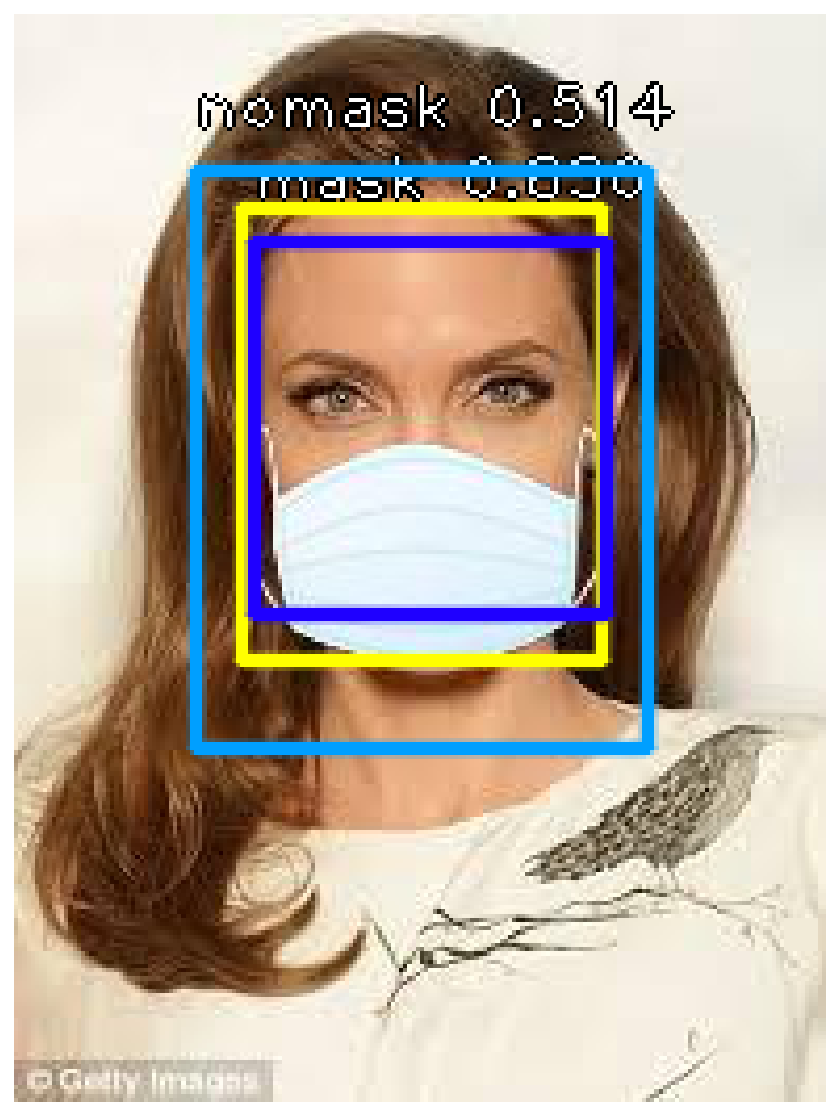

In [34]:
show_detected_objects(test_df.iloc[0])

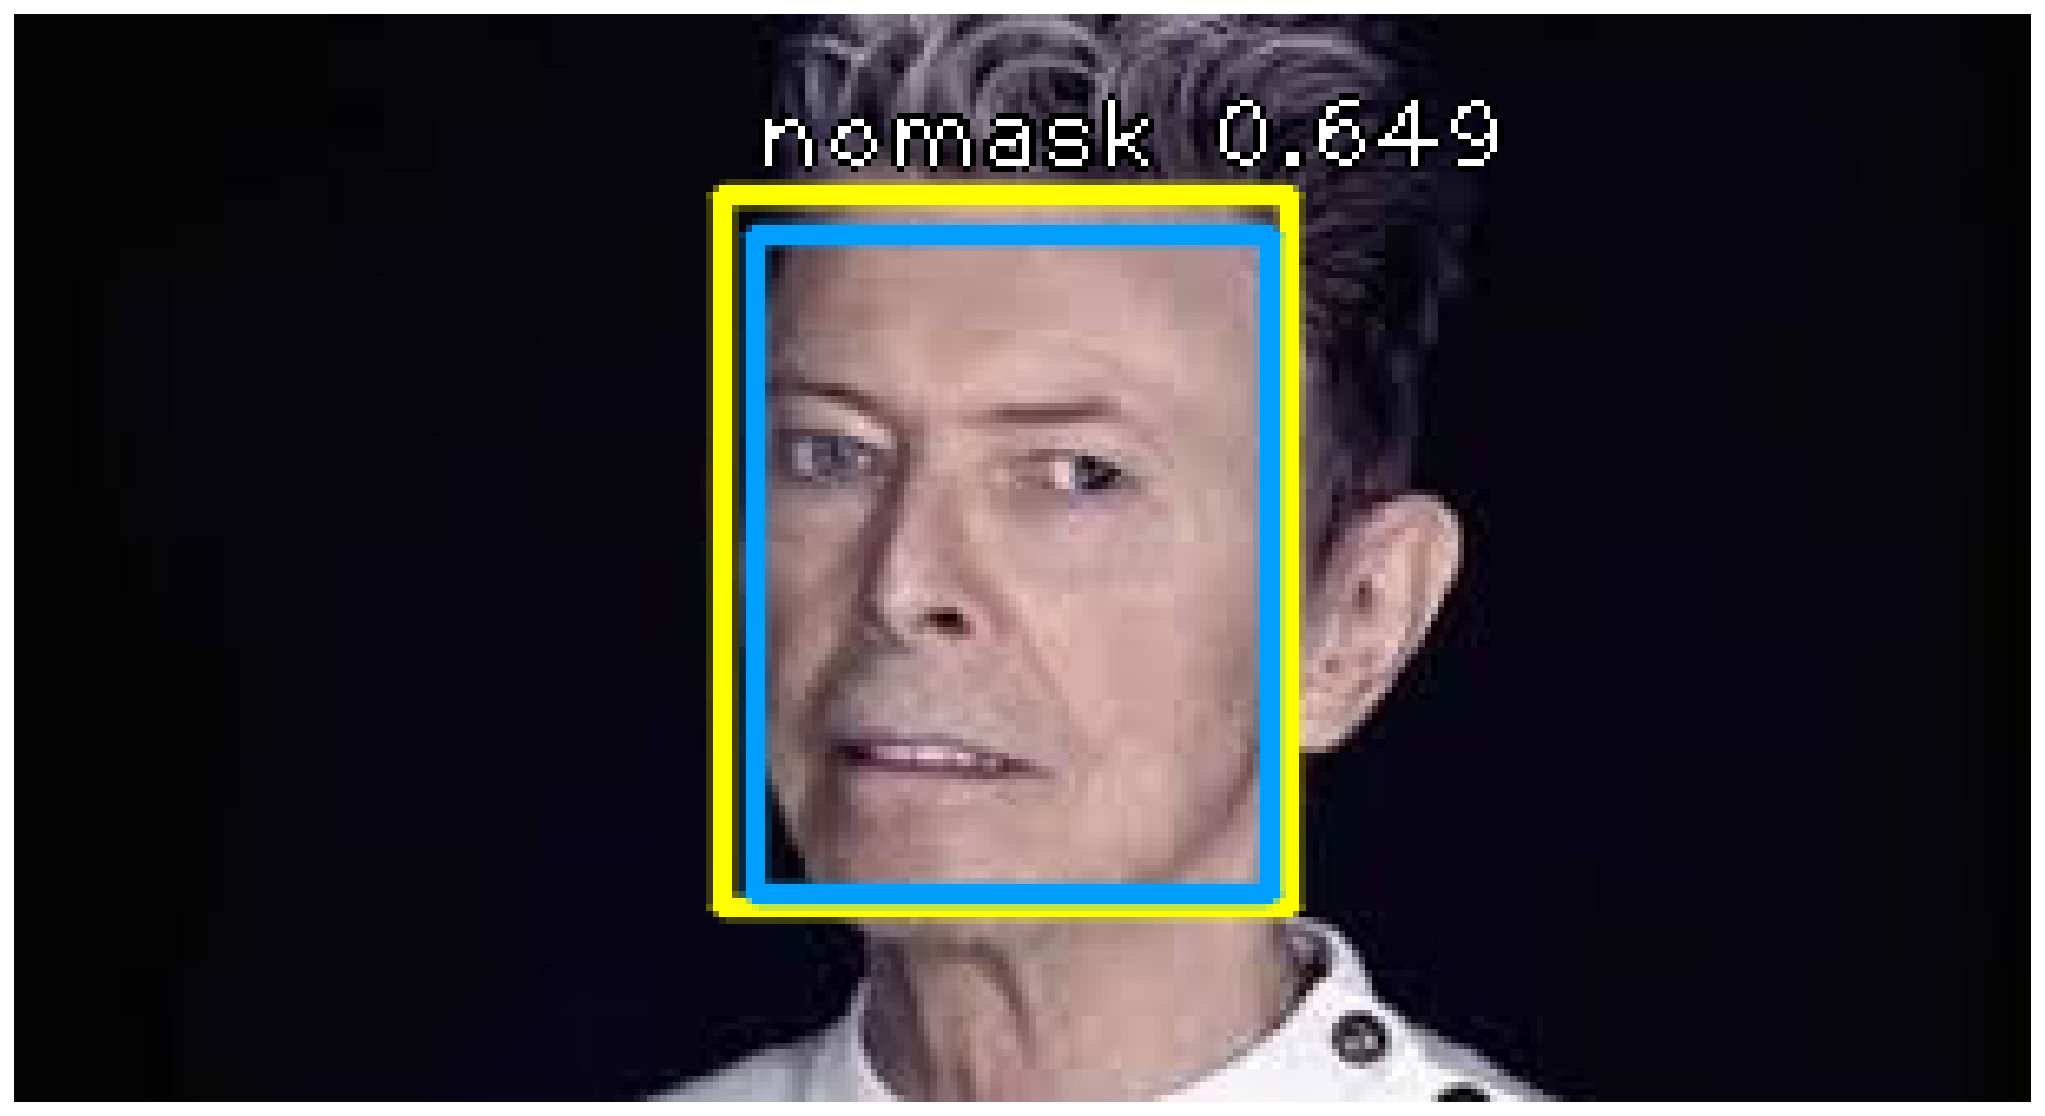

In [35]:
show_detected_objects(test_df.iloc[1])

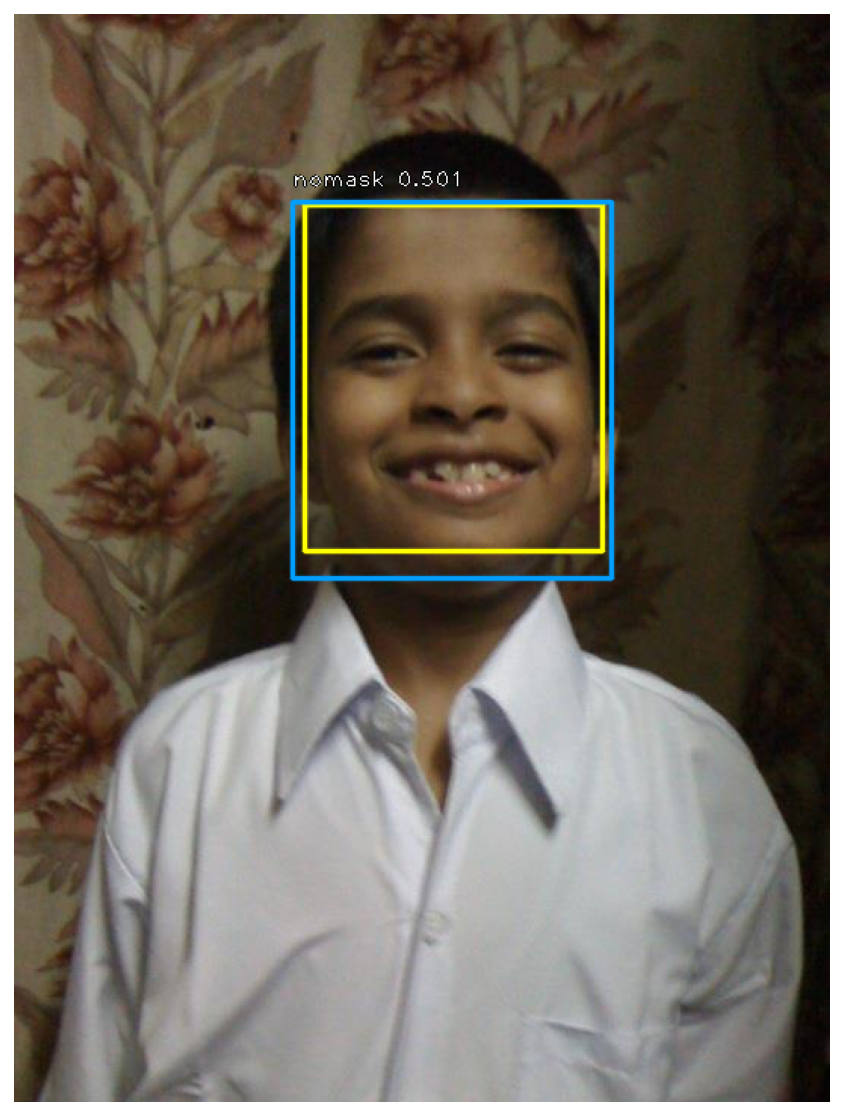

In [36]:
show_detected_objects(test_df.iloc[2])